# Download packages, data, and clean data

You have to jump through some hoops if you want to use Basemap in Google Colab. This code does not require Basemap!!! So only use this if you're interested in matplotlib's basemap.

In [ ]:
# https://stackoverflow.com/questions/54613992/how-to-install-and-use-basemap-on-google-colab

!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

!pip install pyproj==1.9.6

You ***must*** restart the runtime now.

Runtime > Restart runtime

In [44]:
# Google colab doesn't come with Geopandas so you have to install it like this
!pip install geopandas

In [45]:
import geopandas as gpd
import pandas as pd
import numpy as np
import math
from scipy import spatial
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [46]:
##################################
## DOWNLOAD AND CLEAN WELL DATA ##
##################################

"""
Unzip the geodatabase (gdb) and read it using geopandas (gpd). I'm getting the data from the Github repo,
but you could also manually upload the files if you want new data.
I then clean some columns and change the column names for clarity later on.
"""

#Unzip the geodatabase
!wget https://raw.githubusercontent.com/christopher-reed/UCLA-New-Mexico/master/data/geospatial/NMOCD_GISData.gdb.zip
!unzip /content/NMOCD_GISData.gdb.zip

# Parse feature class from gdb
df_wells = gpd.read_file('/content/NMOCD_GISData.gdb')

# Clean spud dates
df_wells['spud_date'] = pd.to_datetime(df_wells['spud_date'], errors = 'coerce')
df_wells['year_spudded'] = df_wells['spud_date'].dt.year
df_wells['effective_date'] = pd.to_datetime(df_wells['effective_date'], errors = 'coerce')
df_wells['plug_date'] = pd.to_datetime(df_wells['plug_date'], errors = 'coerce')

# New column names
# Can use list comprehension bc no edge cases
new_well_column_names = ['well_' + x for x in df_wells.columns]
df_wells.columns = new_well_column_names

######################################
## DOWNLOAD AND CLEAN FACILITY DATA ##
######################################

df_facilities = pd.read_csv('https://raw.githubusercontent.com/christopher-reed/UCLA-New-Mexico/master/data/geospatial/nm_facilities.csv')

# Function to handle edge cases where col name already has facility
def rename_fac_cols(x):

  x = x.lower().replace(' ', '_')

  if 'facility' not in x:
    return 'facility_' + x
  else:
    return x

new_facility_column_names = [rename_fac_cols(x) for x in df_facilities.columns]
df_facilities.columns = new_facility_column_names  

--2021-02-23 01:40:50--  https://raw.githubusercontent.com/christopher-reed/UCLA-New-Mexico/master/data/geospatial/NMOCD_GISData.gdb.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18587889 (18M) [application/zip]
Saving to: ‘NMOCD_GISData.gdb.zip.1’

NMOCD_GISData.gdb.z 100%[===================>]  17.73M  52.2MB/s    in 0.3s    

2021-02-23 01:40:52 (52.2 MB/s) - ‘NMOCD_GISData.gdb.zip.1’ saved [18587889/18587889]

Archive:  /content/NMOCD_GISData.gdb.zip
replace NMOCD_GISData.gdb/a00000001.freelist? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: NMOCD_GISData.gdb/a00000001.freelist  
  inflating: NMOCD_GISData.gdb/a00000001.gdbindexes  
  inflating: NMOCD_GISData.gdb/a00000001.gdbtable  
  inflating: NMOCD_GISData.gdb/a00000001.gdbtablx  
  infla

Look at `df_wells`

In [ ]:
df_wells.head()

,well_id,well_name,well_type_code,well_type,well_status_code,well_status,well_ogrid,well_ogrid_name,well_district_code,well_district,well_county_code,well_county,well_ulstr,well_latitude,well_longitude,well_projection,well_directional_status,well_details,well_files,well_status2,well_symbology,well_year_spudded,well_spud_date,well_measured_vertical_depth,well_true_vertical_depth,well_pool_id_list,well_effective_date,well_plug_date,well_GlobalID,well_geometry
0,30-025-04504,EUNICE MONUMENT SOUTH UNIT #212,O,Oil,A,Active,5380,"XTO ENERGY, INC",1,Hobbs,25,Lea,I-05-21S-36E,32.513210,-103.281082,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,NaN,NaT,3887.0,3887.0,"[23000] EUNICE MONUMENT, GRAYBURG-SAN ANDRES",2004-08-01,NaT,{52967C15-DBDD-4BDE-97C6-C5F9519B3921},POINT (-103.28108 32.51321)
1,30-045-23649,UTE MOUNTAIN UTE #001,O,Oil,A,Active,148219,KEYSTONE ENERGY LLC,3,Aztec,45,San Juan,F-10-31N-15W,36.917633,-108.406952,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,1979.0,1979-07-24,1985.0,1985.0,[62510] VERDE GALLUP,1995-08-01,NaT,{29BEADEC-FD83-49DF-B022-3BD8ED552A07},POINT (-108.40695 36.91763)
2,30-025-29601,EUNICE MONUMENT SOUTH UNIT #338,I,Injection,P,Plugged (site released),5380,"XTO ENERGY, INC",1,Hobbs,25,Lea,P-08-21S-36E,32.487686,-103.280731,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,P,IP,NaN,NaT,4250.0,4250.0,"[23000] EUNICE MONUMENT, GRAYBURG-SAN ANDRES",2004-08-01,2012-04-25,{521F0FE8-CD79-4619-90E7-DA2A5AC73270},POINT (-103.28073 32.48769)
3,30-045-25440,HATCH #001,O,Oil,A,Active,371618,RELIABLE PRODUCTION LLC,3,Aztec,45,San Juan,C-11-29N-15W,36.745640,-108.389458,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,1982.0,1982-10-13,5174.0,5174.0,[11880] CHA CHA GALLUP,2017-03-13,NaT,{9BEF978D-E6A6-4A08-BCAB-EEDED84636AC},POINT (-108.38946 36.74564)
4,30-039-26682,RINCON UNIT #229M,G,Gas,A,Active,372286,"ENDURING RESOURCES, LLC",3,Aztec,39,Rio Arriba,B-34-27N-07W,36.533649,-107.559242,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,GA,2001.0,2001-04-25,7588.0,7588.0,[71599] BASIN DAKOTA (PRORATED GAS); [72319] B...,2017-11-14,NaT,{D380B656-E2EE-4F19-B5D6-F6582D787D17},POINT (-107.55924 36.53365)


Look at `df_facilities`

In [ ]:
df_facilities.head()

,facility_agency_interest_#,facility_type,facility_status,facility_classification,facility_sic_code,facility_name,facility_physical_address,facility_municipality,facility_county,facility_state,facility_zip_code,facility_latitude,facility_longitude,facility_nox_tpy,facility_co_tpy,facility_voc_tpy,facility_pm10_tpy,facility_so2_tpy
0,2,MINING-Screening Plant,Active,No Permit Required,1211.0,"Misc NPRs, NOIs, Permits otherwise not in Tempo",12 miles NW Quemado,Quemado,Catron,NM,87829,34.499884,-108.603880,NaN,NaN,NaN,4.00,NaN
1,3,CON-Concrete Batch Plant,Active,Notice of Intent,3273.0,Derrick Construction - Concrete Batch Plant,1 mile E of Luna,Luna,Catron,NM,87824,33.820546,-108.925531,NaN,NaN,NaN,NaN,NaN
2,5,O&G-Compressor Station,Active,No Permit Required,4922.0,Roundtop Compressor Station,12 miles NW of Roswell,Roswell,Chaves,NM,88201,33.725577,-104.617942,NaN,NaN,NaN,NaN,NaN
3,6,O&G-Compressor Station,Active,Major-Title V,4922.0,Roswell Compressor Station,23 mi N of Roswell,Roswell,Chaves,NM,88201,33.711917,-104.549500,236.40,236.40,58.30,15.60,5.10
4,8,O&G-Compressor Station,Active,Minor,1311.0,IACX - Comanche Compressor Station,19.1 mi NE of Roswell,Roswell,Chaves,NM,88202,33.665391,-104.292592,32.48,32.48,21.04,0.14,0.04


# Find nearest neighbors

In [47]:
#####################################
## CLEAN WELLS AND FACILITIES DATA ##
#####################################

"""
In this example, I focus on active oil and gas wells in Eddy county. I also remove
wells that don't have a recorded geometry. I've also filtered the facilities dataset
to be only active oil and gas facilities in Eddy county with a recorded latitude.
This is the part of the code you want to change if you want to do more counties or use 
different parameters like Plugged wells or something.
"""

df_wells_eddy = df_wells[(df_wells['well_county'] == 'Eddy') &
              ((df_wells['well_type'] == 'Oil') |
              (df_wells['well_type'] == 'Gas')) &
              (df_wells['well_status'] == 'Active') &
              (~df_wells['well_geometry'].isna())].reset_index(drop = True)

df_facilities_eddy = df_facilities[(df_facilities['facility_type'].str.contains('O&G')) &
              (df_facilities['facility_status'] == 'Active') &
              (df_facilities['facility_county'] == 'Eddy') &
              (~df_facilities['facility_latitude'].isna())].reset_index(drop = True)

#######################################
## GET WELL AND FACILITY COORDINATES ##
#######################################

"""
Here, I am using list comprehension to extract the latitude and longitude coordinates.
The result is two lists of tuples: one for wells and one for facilities.
"""

well_coords = [(x,y) for x,y in zip(df_wells_eddy['well_latitude'], df_wells_eddy['well_longitude'])]
fac_coords = [(x,y) for x,y in zip(df_facilities_eddy['facility_latitude'], df_facilities_eddy['facility_longitude'])]

########################################
## FIND NEAREST NEIGHBORS USING KDTREE##
########################################

"""
KDTree is an efficient way to find the closest wells to a given facility. There are certainly
other algorithms that do this. The `k` argument dictates how many wells should be paired with a facility.
For example, this will find the 5 closest wells to each facility. Note that the algorithm is based on
Euclidean distance which can't be interpreted as km. The `p` argument means we are using Euclidean distance.
You'll need to find the distance in km separately if you want to.
"""

tree = spatial.KDTree(well_coords)
result = tree.query(fac_coords,
                    k = 5,
                    p = 2)

####################
## UNPACK RESULTS ##
####################

"""
The `result` variable returns the distance between a well and facility as well as the index position of the well.
We can use the index position later to merge (join) these results. I'm also creating a list of the `agency_interest_#` values.
Each value is repeated 5 times here because we asked for 5 neighbors. If you want 3 neighbors, change that value to 3.
I then package everything up into a Pandas dataframe. 
"""

euc_dist = np.ravel(result[0])
well_index = np.ravel(result[1])
fac_id = np.repeat(df_facilities_eddy['facility_agency_interest_#'].to_list(), 5)

output = pd.DataFrame(data = [fac_id, well_index, euc_dist],
                      index = ['facility_agency_interest_#', 'well_index', 'euc_dist']).T

#############################
## JOIN AND FORMAT RESULTS ##
#############################

"""
Think of the variable `output` as a bridge between `df_wells_eddy` and `df_facilities_eddy`. Since I know the
`agency_interest_#,` I can join the rest of the facilities information to our output. Simmilarly, since I know
the `well_index,` I know what row of `df_wells_eddy` my output refers to. For example, a `well_index` of 183 refers
to the 183 row of `df_wells_eddy.`
"""

df_result = output.merge(df_wells_eddy, left_on = 'well_index', right_index = True)
df_result = df_result.merge(df_facilities_eddy, on = 'facility_agency_interest_#')

######################################################
## FIND DISTANCE BETWEEN MATCHED FACILITY-WELL PAIR ##
######################################################

"""
The Euclidean distance we found earlier is good for knowing which well is the closest/farthest from a facility,
but it cannot be interpreted as km. We can make better decisions about whether a well-facility pair is real based
on distances we can interpret. Since the Earth is round, we should use Haversine distance although the distances
are probably short enough where Earth's curvature doesn't matter that much.
"""

# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

df_result['well_facility_distance_km'] = haversine(lat1 = df_result['well_latitude'],
                                                       lon1 = df_result['well_longitude'],
                                                       lat2 = df_result['facility_latitude'],
                                                       lon2 = df_result['facility_longitude'])


Check out `df_result`

In [48]:
# Save as csv
df_result.to_csv('eddy_county_nm_well_facility_pairs.csv', index = False)

# Inspect
df_result.head()

,facility_agency_interest_#,well_index,euc_dist,well_id,well_name,well_type_code,well_type,well_status_code,well_status,well_ogrid,well_ogrid_name,well_district_code,well_district,well_county_code,well_county,well_ulstr,well_latitude,well_longitude,well_projection,well_directional_status,well_details,well_files,well_status2,well_symbology,well_year_spudded,well_spud_date,well_measured_vertical_depth,well_true_vertical_depth,well_pool_id_list,well_effective_date,well_plug_date,well_GlobalID,well_geometry,facility_type,facility_status,facility_classification,facility_sic_code,facility_name,facility_physical_address,facility_municipality,facility_county,facility_state,facility_zip_code,facility_latitude,facility_longitude,facility_nox_tpy,facility_co_tpy,facility_voc_tpy,facility_pm10_tpy,facility_so2_tpy,well_facility_distance_km
0,191.0,9349.0,0.001492,30-015-00754,EMPIRE ABO UNIT #012B,O,Oil,A,Active,873,APACHE CORPORATION,2,Artesia,15,Eddy,I-03-18S-27E,32.774643,-104.259880,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,1900.0,1900-02-01,6105.0,6105.0,"[22040] EMPIRE, ABO",2011-01-11,NaT,{4C21621A-A1D2-4736-9957-67F948B7ADD2},POINT (-104.25988 32.77464),O&G-Gas Plant,Active,Major-Title V,1321.0,Durango Midstream - Empire Abo Gas Plant - CS,10 miles E of Artesia,Artesia,Eddy,NM,88210,32.776122,-104.259683,201.7,110.9,112.9,8.1,239.6,0.165498
1,191.0,9500.0,0.001809,30-015-00755,EMPIRE ABO UNIT #012C,O,Oil,A,Active,873,APACHE CORPORATION,2,Artesia,15,Eddy,H-03-18S-27E,32.777912,-104.259941,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,1900.0,1900-02-01,6123.0,6123.0,"[22040] EMPIRE, ABO",2011-01-11,NaT,{15533230-B1DD-4D45-85AE-9F9779163360},POINT (-104.25994 32.77791),O&G-Gas Plant,Active,Major-Title V,1321.0,Durango Midstream - Empire Abo Gas Plant - CS,10 miles E of Artesia,Artesia,Eddy,NM,88210,32.776122,-104.259683,201.7,110.9,112.9,8.1,239.6,0.200507
2,191.0,9894.0,0.002675,30-015-29545,FALCON 3 H FEDERAL #010,O,Oil,A,Active,330211,Redwood Operating LLC,2,Artesia,15,Eddy,H-03-18S-27E,32.778717,-104.259033,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,1997.0,1997-07-02,2793.0,2793.0,"[51300] RED LAKE, QUEEN-GRAYBURG-SA",2020-09-18,NaT,{7F1C3D7B-DE53-476D-A93B-04ABE9BB186C},POINT (-104.25903 32.77872),O&G-Gas Plant,Active,Major-Title V,1321.0,Durango Midstream - Empire Abo Gas Plant - CS,10 miles E of Artesia,Artesia,Eddy,NM,88210,32.776122,-104.259683,201.7,110.9,112.9,8.1,239.6,0.294877
3,191.0,8668.0,0.003910,30-015-22342,FEDERAL F #001,O,Oil,A,Active,328947,Spur Energy Partners LLC,2,Artesia,15,Eddy,G-03-18S-27E,32.777908,-104.263161,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,1979.0,1979-11-23,9957.0,9957.0,"[11960] CHALK BLUFF, WOLFCAMP",2019-12-10,NaT,{3969FED6-6B1C-4FA0-AB66-9F31BFEAA31A},POINT (-104.26316 32.77791),O&G-Gas Plant,Active,Major-Title V,1321.0,Durango Midstream - Empire Abo Gas Plant - CS,10 miles E of Artesia,Artesia,Eddy,NM,88210,32.776122,-104.259683,201.7,110.9,112.9,8.1,239.6,0.381005
4,191.0,9848.0,0.003930,30-015-22062,EMPIRE ABO UNIT #121,O,Oil,A,Active,873,APACHE CORPORATION,2,Artesia,15,Eddy,P-03-18S-27E,32.772427,-104.258347,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,1977.0,1977-04-27,6157.0,6157.0,"[22040] EMPIRE, ABO",2011-01-11,NaT,{A34A0B0D-2A02-45CF-94A0-C077991CA151},POINT (-104.25835 32.77243),O&G-Gas Plant,Active,Major-Title V,1321.0,Durango Midstream - Empire Abo Gas Plant - CS,10 miles E of Artesia,Artesia,Eddy,NM,88210,32.776122,-104.259683,201.7,110.9,112.9,8.1,239.6,0.429486


Case study with facility #207

In [49]:
# I'm only looking at a few columns for one facility here
df_result[df_result['facility_agency_interest_#'] == 207][['facility_name', 'well_name', 'well_id', 'well_facility_distance_km', 'well_latitude', 'well_longitude']]

,facility_name,well_name,well_id,well_facility_distance_km,well_latitude,well_longitude
170,Atoka No1 Compressor Station,AAO FEDERAL #004,30-015-32310,0.083176,32.780518,-104.226776
171,Atoka No1 Compressor Station,AAO FEDERAL #024,30-015-42337,0.148525,32.780510,-104.224350
172,Atoka No1 Compressor Station,AAO FEDERAL #017,30-015-42027,0.184242,32.778698,-104.226372
173,Atoka No1 Compressor Station,AAO FEDERAL #008,30-015-33784,0.217479,32.778683,-104.224632
174,Atoka No1 Compressor Station,AAO FEDERAL #014,30-015-42024,0.335166,32.782864,-104.224014


# Plotting

Just facility 207 and it's 5 neighbor wells

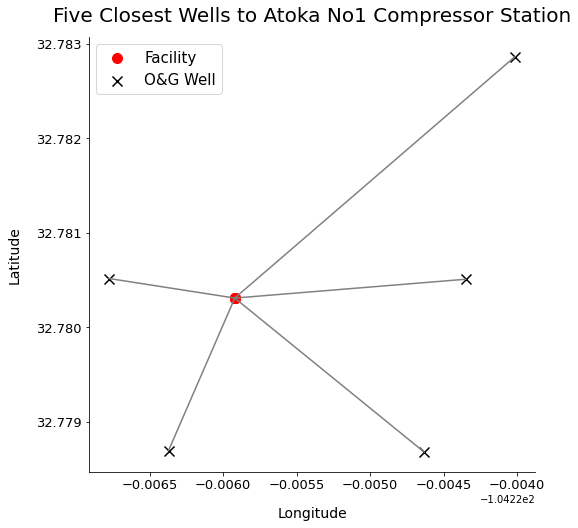

In [50]:
# Filter to one facility
one_fac = df_result[df_result['facility_agency_interest_#'] == 207]

# Create fig and ax
fig, ax = plt.subplots(figsize = (8,8))

# For each well associated with the one facility....
for i in np.arange(one_fac.shape[0]):

  # Extract well coords
  well_lon = one_fac.iloc[i]['well_longitude']
  well_lat = one_fac.iloc[i]['well_latitude']

  # Extract fac coords
  fac_lon = one_fac.iloc[i]['facility_longitude']
  fac_lat = one_fac.iloc[i]['facility_latitude']

  # Plot well and facility
  ax.scatter(fac_lon, fac_lat,
             marker = 'o',
             s = 100,
             label = 'Facility',
             color = 'red')
  ax.scatter(well_lon, well_lat,
             marker = 'x',
             s =100,
             color = 'black',
             label = 'O&G Well')

  # Draw connectin lines
  ax.plot([well_lon, fac_lon], [well_lat, fac_lat],
          color = 'grey')


############
## LEGEND ##
############

handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels, loc='best', prop = {'size': 15})

################
## FORMATTING ##
################


ax.set_title('Five Closest Wells to Atoka No1 Compressor Station', fontsize = 20, pad = 15)
ax.set_xlabel('Longitude', fontsize = 14, labelpad = 15)
ax.set_ylabel('Latitude', fontsize = 14, labelpad = 15)
ax.tick_params(axis = 'both', labelsize = 13)

ax = sns.despine()

All facilities and connections in a gridbox in Eddy County, NM. You'll notice that there are some long connections and that some wells are connected to two facilities. You'll need to figure out how to interpret the double matched wells.

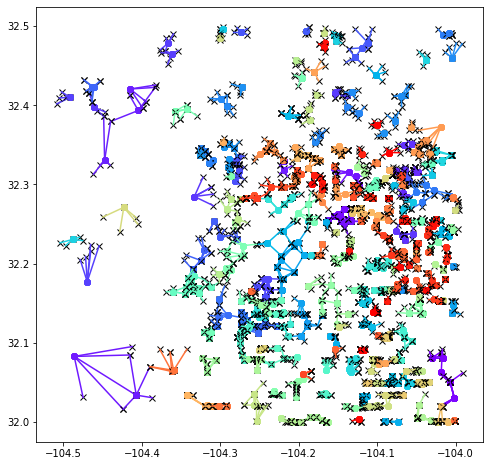

In [51]:
df_subset_result = df_result[(df_result['facility_longitude'] < -104) & (df_result['facility_longitude'] > -104.5) &
                            (df_result['facility_latitude'] > 32) & (df_result['facility_latitude'] < 32.5)]

sample_facs = df_subset_result['facility_agency_interest_#'].unique()
from matplotlib import cm
color=iter(cm.rainbow(np.linspace(0,1,len(sample_facs))))

fig, ax = plt.subplots(figsize = (8,8))

for fac in sample_facs:

  one_fac = df_subset_result[df_subset_result['facility_agency_interest_#'] == fac]

  c = next(color)

  for i in np.arange(one_fac.shape[0]):

    well_lon = one_fac.iloc[i]['well_longitude']
    well_lat = one_fac.iloc[i]['well_latitude']

    fac_lon = one_fac.iloc[i]['facility_longitude']
    fac_lat = one_fac.iloc[i]['facility_latitude']

    ax.plot(fac_lon, fac_lat, marker = 'o', color = c)
    ax.plot(well_lon, well_lat, marker = 'x', color = 'black')

    ax.plot([well_lon, fac_lon], [well_lat, fac_lat], color = c)

We get some very long connections with are probably unrealistic. In this next plot, I only consider connections that are less than 500 meters.

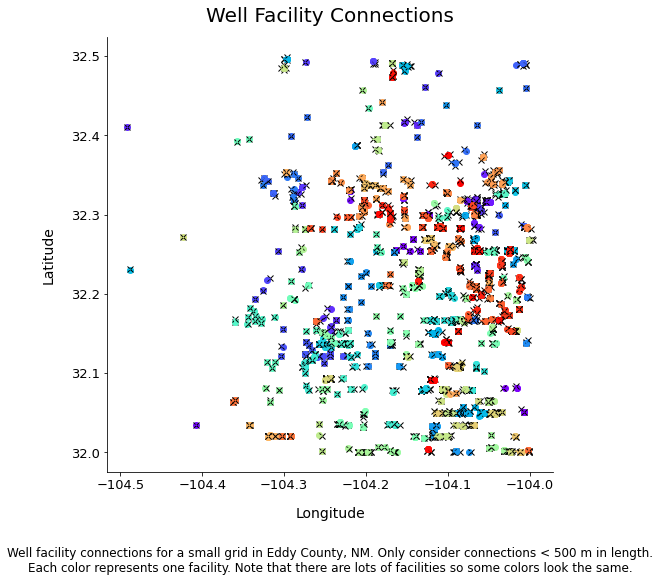

In [52]:
# Define box to limit facility locations
df_subset_result = df_result[(df_result['facility_longitude'] < -104) & (df_result['facility_longitude'] > -104.5) &
                            (df_result['facility_latitude'] > 32) & (df_result['facility_latitude'] < 32.5)]

# Only include wells that are less than 500 meters from a facility. 
df_subset_result = df_subset_result[df_subset_result['well_facility_distance_km'] < 0.5]

sample_facs = df_subset_result['facility_agency_interest_#'].unique()
from matplotlib import cm
color=iter(cm.rainbow(np.linspace(0,1,len(sample_facs))))

fig, ax = plt.subplots(figsize = (8,8))

for fac in sample_facs:

  one_fac = df_subset_result[df_subset_result['facility_agency_interest_#'] == fac]

  c = next(color)

  for i in np.arange(one_fac.shape[0]):

    well_lon = one_fac.iloc[i]['well_longitude']
    well_lat = one_fac.iloc[i]['well_latitude']

    fac_lon = one_fac.iloc[i]['facility_longitude']
    fac_lat = one_fac.iloc[i]['facility_latitude']

    ax.plot(fac_lon, fac_lat, marker = 'o', color = c)
    ax.plot(well_lon, well_lat, marker = 'x', color = 'black')

    ax.plot([well_lon, fac_lon], [well_lat, fac_lat], color = c)


################
## FORMATTING ##
################

# Caption
ax.text(0.5,-0.23,
        'Well facility connections for a small grid in Eddy County, NM. Only consider connections < 500 m in length.\nEach color represents one facility. Note that there are lots of facilities so some colors look the same.',
        fontsize = 12,
        ha = 'center',
        transform = ax.transAxes)

ax.set_title('Well Facility Connections', fontsize = 20, pad = 15)
ax.set_xlabel('Longitude', fontsize = 14, labelpad = 15)
ax.set_ylabel('Latitude', fontsize = 14, labelpad = 15)
ax.tick_params(axis = 'both', labelsize = 13)

ax = sns.despine()

All facilities and connection in Eddy County, NM (ugly and not that useful)

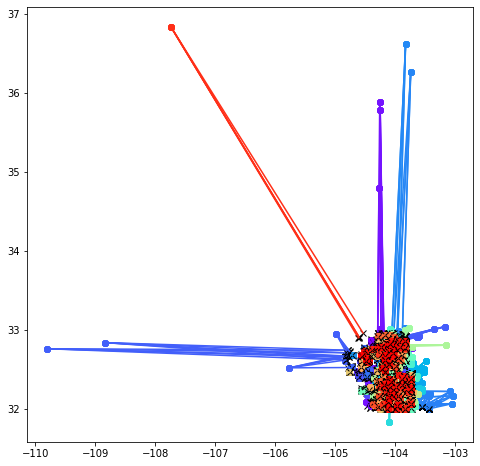

In [ ]:
sample_facs = df_result['facility_agency_interest_#'].unique()
from matplotlib import cm
color=iter(cm.rainbow(np.linspace(0,1,len(sample_facs))))

fig, ax = plt.subplots(figsize = (8,8))

for fac in sample_facs:

  one_fac = df_result[df_result['facility_agency_interest_#'] == fac]

  c = next(color)

  for i in np.arange(one_fac.shape[0]):

    well_lon = one_fac.iloc[i]['well_longitude']
    well_lat = one_fac.iloc[i]['well_latitude']

    fac_lon = one_fac.iloc[i]['facility_longitude']
    fac_lat = one_fac.iloc[i]['facility_latitude']

    ax.plot(fac_lon, fac_lat, marker = 'o', color = c)
    ax.plot(well_lon, well_lat, marker = 'x', color = 'black')

    ax.plot([well_lon, fac_lon], [well_lat, fac_lat], color = c)

# ax.set_xlim(left = -104.1, right = -103.9)
# ax.set_ylim(bottom = 32, top = 32.10)